In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import os
import pathlib
import random

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, \
    ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, \
    InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB3

from keras import regularizers

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, \
    Flatten, BatchNormalization, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, \
    EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

import dask.bag as bag
import tqdm

from typing import *
from collections import Counter

import yaml

import warnings
warnings.filterwarnings('ignore')

# Описание проекта

Задача - создать модель машинного обучения для определения ромашки лекарственной и ее примесей по фото.

Ромашка аптечная (Matricaria chamomilla) — это растение, цветки которого используются в качестве лекарственного сырья и лекарственного средства. Препараты ромашки аптечной назначают как противовоспалительное, спазмолитическое средство при спазмах кишечника, метеоризме и других расстройствах деятельности желудочно-кишечного тракта. Наружно — для полоскания рта, для клизм, ванн. Сырьё обладает антиаллергическим действием.

При сборе цветков ромашки ее следует отличать от других растений, похожих на нее по внешнему виду, но не являющихся лекарственными. Данная задача является крайне необходимой для обеспечения качества и безопасности лекарственных средств и здоровья потребителей:

- сбор лекарственных растений - это важный этап в производстве качественных медикаментов, ведь от качества сырья зависит эффективность и безопасность конечного продукта;
- модель машинного обучения позволит автоматизировать процесс идентификации растений, что существенно ускорит и упростит процесс сбора и обработки сырья. Это, в свою очередь, позволит сократить затраты на ручной труд и повысит эффективность работы специалистов;
- модель поможет людям, которые не обладают достаточными знаниями в области ботаники, быстро и точно определить, является ли цветок, который они видят, ромашкой или нет. Это особенно важно в случае, если человек собирается использовать ромашку аптечную для лечебных целей, так как неправильное определение может привести к нежелательным последствиям;
- также модель может быть полезна для фермеров, которые выращивают ромашку для продажи или использования в косметической или фармацевтической промышленности. Она поможет исключить возможность попадания примесей в продукцию, что может повлиять на ее качество и стоимость. 

Для анализа взяты следующий растения:
- Ромашка аптечная (Matricaria chamomilla);
- Ромашка непахучая, или Трёхрёберник (Tripleurospermum inodorum);
- Ромашка пахучая (Matricaria discoidea);
- виды Пупавки (Anthemis cotula, Anthemis arvensis, Anthemis ruthenica);
- виды Пиретрума (Tanacetum parthenium, Tanacetum corymbosum);
- Поповник, или Нивяник (Leucanthemum vulgare).

Для решения задачи классификации будем использовать CNN.

# Import data

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


preproc = config['preprocessing']
training = config['train']

In [3]:
# загрузим таблицу, которая содержит путь до фото и соотв метки классов
df = pd.read_csv(preproc['train_path_proc'])

In [5]:
df.head()

,img,label
0,../data/processed/train//anthemis_arvensis/001...,anthemis_spec
1,../data/processed/train//anthemis_arvensis/001...,anthemis_spec
2,../data/processed/train//anthemis_arvensis/001...,anthemis_spec
3,../data/processed/train//anthemis_arvensis/00e...,anthemis_spec
4,../data/processed/train//anthemis_arvensis/00e...,anthemis_spec


In [6]:
df.shape

(102086, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102086 entries, 0 to 102085
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   img     102086 non-null  object
 1   label   102086 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [8]:
df.describe()

,img,label
count,102086,102086
unique,102086,6
top,../data/processed/train//anthemis_arvensis/001...,matricaria_discoidea
freq,1,20515


# EDA

## Анализ баланса классов

In [9]:
# посмотрим абсолютное количество
image_count = df.shape[0]
cls_names = df['label'].unique()
print(f'Total images: {image_count}')
print('-'*30)
print(f'Total number of classes: {len(cls_names)}')
print('-'*30)
for cls_name, num_cls in Counter(df['label']).items():
    print(f'Total {cls_name} images: {num_cls}')

Total images: 102086
------------------------------
Total number of classes: 6
------------------------------
Total anthemis_spec images: 6423
Total leucanthemum_vulgare images: 20500
Total matricaria_chamomilla images: 13770
Total matricaria_discoidea images: 20515
Total pyrethrum_spec images: 20434
Total tripleurospermum_inodorum images: 20444


In [10]:
# посмотрим в процентном соотношении
def barplot_make(data: pd.DataFrame, target: str) -> None:
    """
    Построение barplot с указанием значений над столбцами.
    
    Parameters
    ----------
    data: pd.DataFrame
        Данные.
    target: str
        Название столбца для нормирования данных.
        
    Returns
    -------
    None
        Выводит график barplot с указанием значений над столбцами.
    """
    data_label = data[target].value_counts(
    normalize=True).mul(100).rename('percent').reset_index()
    
    plt.figure(figsize=(10, 6))
    

    ax = sns.barplot(x=target,
                     y="percent",
                     data=data_label,
                     palette='viridis')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        if p.get_height() != 0:
            ax.annotate(
                percentage,  # текст
                # координата xy
                (p.get_x() + p.get_width() / 2., p.get_height()),
                # центрирование
                ha='center',
                va='center',
                xytext=(0, 7),
                # точка смещения относительно координаты
                textcoords='offset points',
                fontsize=12)

    plt.title('Соотношение классов', fontsize=16)
    plt.xlabel(target, fontsize=12)
    plt.xticks(rotation = 45)
    plt.ylabel('Percent', fontsize=12)
    
    plt.show()

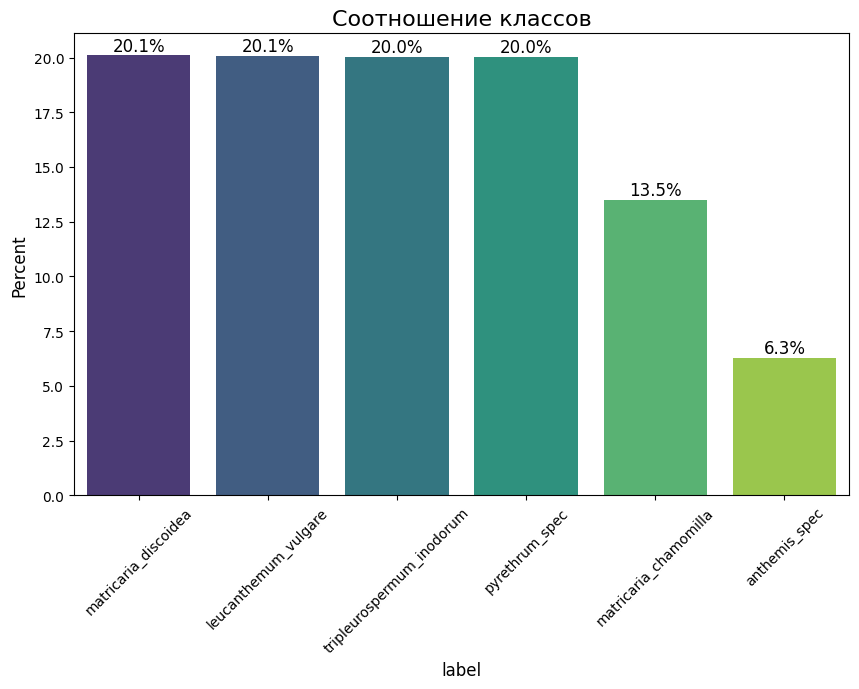

In [11]:
barplot_make(data=df, target='label')

**Вывод:**

- наблюдается дисбаланс классов

## Размеры изображений

Посмотрим размеры изображений в датасете

In [11]:
def get_dims(file: str) -> tuple[int, int]:
    """
    Возвращает размеры RGB изображения.
    
    Parameters
    ----------
    file: str
        Путь к файлу изображения.
        
    Returns
    -------
    tuple[int, int]
        Кортеж с высотой и шириной изображения.
    """
    im = Image.open(file)
    arr = np.array(im)
    h, w, d = arr.shape
    
    return h, w


def image_size_plot(data, col_img, col_label) -> None:
    """
    Строит график размеров изображений по классам.
    
    Parameters
    ----------
    directories : dict[str, str]
        Словарь с именами классов и путями к папкам с изображениями.
        
    Returns
    -------
    None
        Выводит график размеров изображений по классам.
    """
    img_classes = data[col_label].unique().tolist()
    
    plt.figure(figsize=(15, 10))
    ncols = 3
    nrows = len(img_classes) // 3 + 1

    for i, label in tqdm.tqdm(enumerate(img_classes)):
        data_cls = data[data[col_label]==label]
        filelist = [f for f in data_cls[col_img][:30]]
        dims = bag.from_sequence(filelist).map(get_dims)
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(
            ['height',
             'width']).size().reset_index().rename(columns={0: 'count'})
        plt.subplot(nrows, ncols, i + 1)
        sns.scatterplot(
            data=dim_df,
            x='width',
            y='height',
            palette='viridis',
        )
        plt.title('Image Sizes (pixels) | {}'.format(label))
    plt.tight_layout()
    plt.show()

6it [00:04,  1.43it/s]


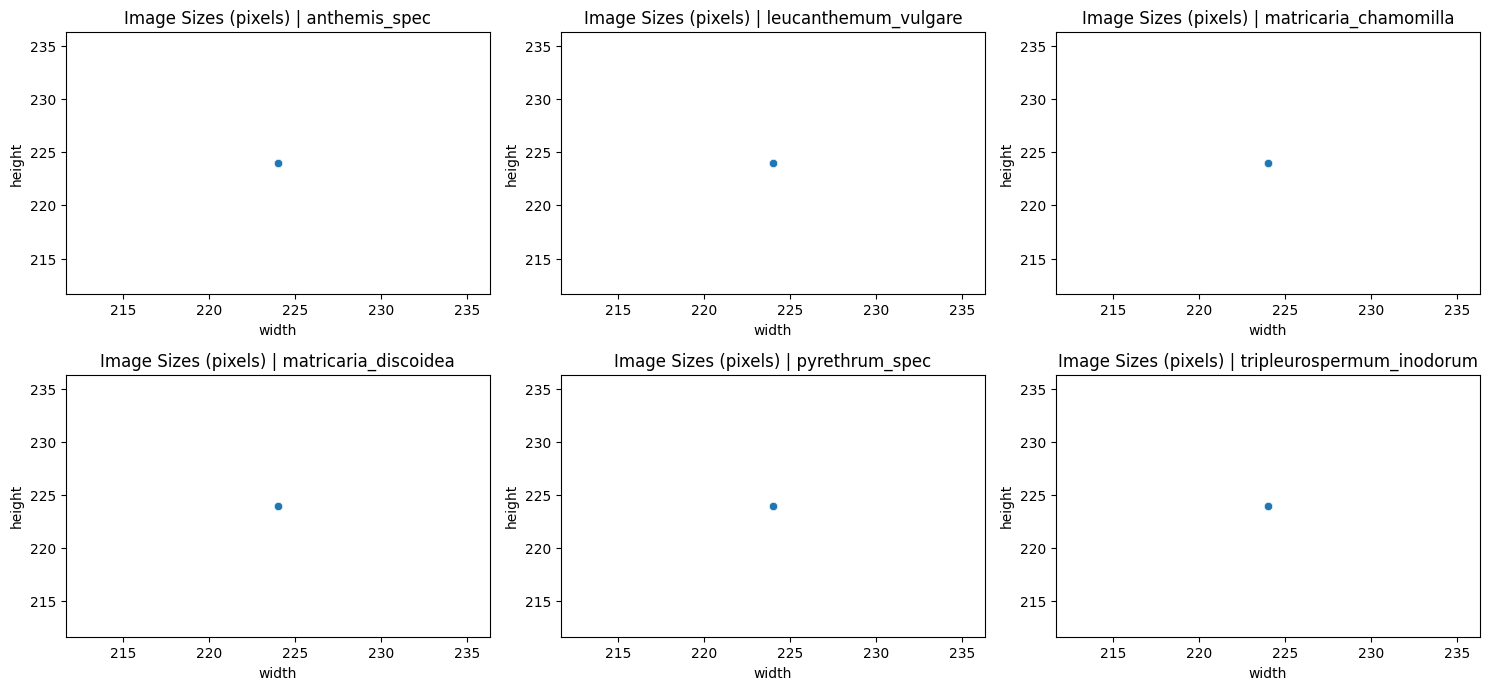

In [12]:
image_size_plot(data=df, col_img='img', col_label='label')

**Вывод:**
    
- в датасете фото одного размера.

## Примеры фото

In [12]:
def cls_example(data: pd.DataFrame, col_img: str, col_cls: str) -> None:
    """
    Показывает примеры изображений каждого класса.
    
    Parameters
    ----------
    data: pd.DataFrame:
        Данные.
    col_img: str
        Колонка с путем к изображениям.
    col_cls: str
        Колонка с метками классов.
        
    Returns
    -------
    None
        Выводит примеры изображений каждого класса.
    """
    
    names_cls = data[col_cls].unique().tolist()
    
    # определим размеры графика и количество axes
    ncols = 3
    nrows = len(names_cls) // 3 + 1
    plt.figure(figsize=(10, 10))
    
    # пройдем по каждому классу
    for i, label in enumerate(names_cls):
        df_target = data[data[col_cls]==label]
        np.random.seed(26)
        random_num = np.random.randint(0, df_target.shape[0])
        image_path = df_target[col_img].iloc[random_num]
        img = plt.imread(image_path)
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

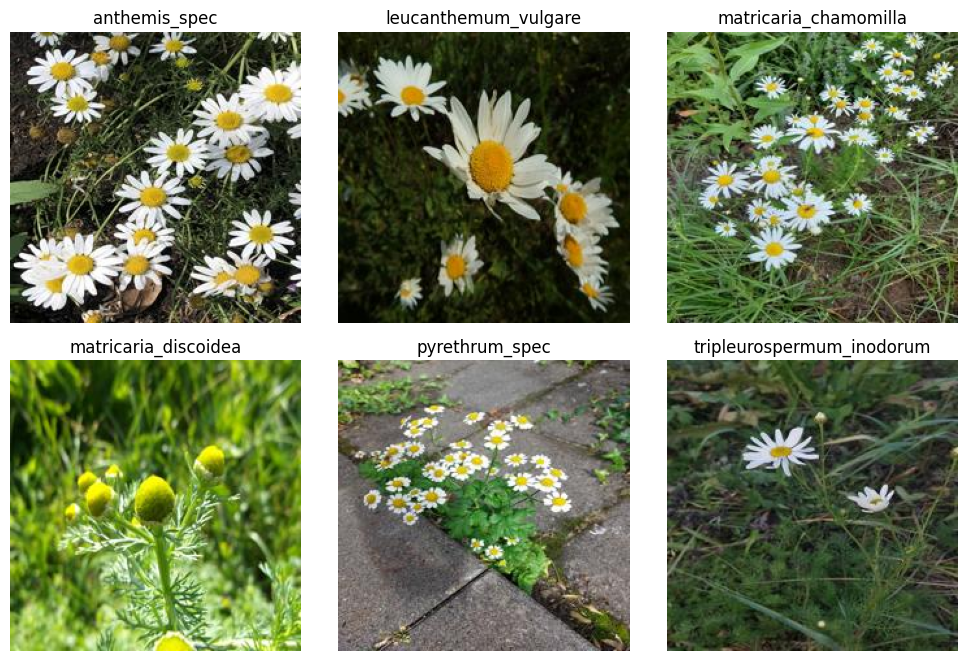

In [13]:
cls_example(data=df, col_img='img', col_cls='label')

**Вывод:**
    
- больше всего отличабются виды matricaria_discoidea и виды pyrethrum_spec;
- больше всего схожи между собой виды anthemis, matricaria_chamomilla и tripleurospermum_inodorum.

# Data preprocessing

In [16]:
# определим параметры
test_size = training['test_size']
val_size = training['val_size']
target_column = training['target_column']
image_size = (training['img_size'], training['img_size'])
img_shape = (image_size[0], image_size[1], training['channels'])
batch_size = training['batch_size']
n_class = training['n_class']
n_epoch_train = training['n_epoch_train']
n_epoch_fine = training['n_epoch_fine']
RAND = training['random_state']

## Data splitting

In [5]:
# разделим данные на train, val, test
df_train_, df_test = train_test_split(df,
                                      test_size=test_size,
                                      stratify=df[target_column],
                                      random_state=RAND)

df_train, df_val = train_test_split(df_train_,
                                    test_size=val_size,
                                    stratify=df_train_[target_column],
                                    random_state=RAND)

In [6]:
# посмотрим на размер разделенных данных
print(f"Размер train: {df_train.shape}")
print(f"Размер validation: {df_val.shape}")
print(f"Размер test: {df_test.shape}")

Размер train: (68601, 2)
Размер validation: (13067, 2)
Размер test: (20418, 2)


## Data Generators

In [7]:
# создадим ImageDataGenerator для увеличения разнообразия изображений
# для тренировочных данных
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.9, 1.1],
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

# для валидационных и тестовых данных
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
# создадим генератор для тренировочных данных
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='img',
                                                    y_col='label',
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    color_mode="rgb",
                                                    seed=RAND)

# создадим генератор для валидационных данных
val_generator = test_datagen.flow_from_dataframe(df_val,
                                                 x_col='img',
                                                 y_col='label',
                                                 target_size=image_size,
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=False,
                                                 color_mode="rgb",
                                                 seed=RAND)

# создадим генератор для тестовых данных
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  x_col='img',
                                                  y_col='label',
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  color_mode="rgb",
                                                  seed=RAND)

Found 68601 validated image filenames belonging to 6 classes.
Found 13067 validated image filenames belonging to 6 classes.
Found 20418 validated image filenames belonging to 6 classes.


## Imbalanced Data Handling

In [9]:
# создадим словарь с соответсвием закодированных меток классов
label_map = train_generator.class_indices
label_map

{'anthemis_spec': 0,
 'leucanthemum_vulgare': 1,
 'matricaria_chamomilla': 2,
 'matricaria_discoidea': 3,
 'pyrethrum_spec': 4,
 'tripleurospermum_inodorum': 5}

In [65]:
# сохраним label_map для дальнейшего предсказания классов
label_map_path = training['label_map_path']

with open(label_map_path, 'w') as f:
    json.dump(label_map, f)

In [10]:
# учтем дисбаланс классов 
# создадим словарь с весами
cls_wt = class_weight.compute_class_weight(class_weight='balanced',
                                           classes=np.unique(
                                               train_generator.classes),
                                           y=train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), cls_wt))
class_weights

{0: 2.6490963855421685,
 1: 0.8299578977932637,
 2: 1.2356533016319031,
 3: 0.8293558682721601,
 4: 0.8326172443926595,
 5: 0.8322536031445625}

# Modeling

## Creating the Model

In [21]:
# определим функцию для создания модели
def create_model(base_model_name: Union[InceptionV3, EfficientNetB3,
                                        MobileNetV2, ResNet50, VGG16],
                 img_shape: Tuple[int, int, int],
                 n_class: int,
                 rand_seed: int,
                 optimizer: Type[Adam],
                 test_flg: bool = False) -> Sequential:
    """
    Создает модель нейронной сети на основе заданной базовой модели.
    
    Parameters
    ----------
    base_model_name: Union[InceptionV3, EfficientNetB3, 
                           MobileNetV2, ResNet50, VGG16]
        Базовая модель.
    img_shape: Tuple[int, int, int]
        Размер входного изображения.
    n_class: int
        Количество классов.
    rand_seed: int
        random_state для воспроизводимости результата.
    optimizer: Type[Adam]
        Оптимизатор для модели.
    test_flg: bool
        Цель создания модели (True для тестирования, иначе для классификации).
    
    Returns
    -------
    Sequential
        Созданная модель нейронной сети.
    """
    # создадим базовую модель
    base_model = base_model_name(weights='imagenet',
                                 include_top=False,
                                 input_shape=img_shape)
    # заморозим слои (в зависимсоти от цели создания модели)
    if test_flg:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        no_base_layers = len(base_model.layers)
        no_finetune_layers = int(no_base_layers / 4)
        base_model.trainable = True
        for layer in base_model.layers[:-no_finetune_layers]:
            layer.trainable = False

    # создадим модель CNN на основе базовой модели
    model = Sequential()
    model.add(Input(shape=img_shape))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    if test_flg:
        # для тестирования базовых моделей
        model.add(
            Dense(32,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(rate=0.2, seed=rand_seed))
        model.add(Dense(n_class, activation='softmax'))
    else:
        # для классификации
        model.add(
            Dense(256,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(rate=0.2, seed=rand_seed))
        model.add(
            Dense(128,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(rate=0.1, seed=rand_seed))
        model.add(Dense(n_class, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.metrics.F1Score(average='macro')])

    return model

In [12]:
# определим функцию для callbacks
def callbacks_make(checkpoint_path: str,
                   checkpoint_flg: bool = False,
                   reduce_lr_flg: bool = False) -> List:
    """
    Создает список callbacks для обучения модели.
    
    Parameters
    ----------
    checkpoint_path: str
        Путь для сохранения checkpoint.
    checkpoint_flg: bool
        Флаг использования ModelCheckpoint.
    reduce_lr_flg: bool
        Флаг использования ReduceLROnPlateau.
    
    Returns
    -------
    List
        Список callbacks.
    """
    early_stopping = EarlyStopping(monitor='val_f1_score',
                                   patience=5,
                                   mode='max', 
                                   verbose=0,
                                   restore_best_weights=False)
    callbacks = [early_stopping]

    if checkpoint_flg:
        checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                     save_weights_only=True,
                                     monitor='val_f1_score',
                                     mode='max', 
                                     verbose=1,
                                     save_best_only=True)
        callbacks.append(checkpoint)

    if reduce_lr_flg:
        reduce_lr = ReduceLROnPlateau(monitor="val_f1_score",
                                      min_lr=0.0000001,
                                      mode='max', 
                                      patience=2,
                                      verbose=1)
        callbacks.append(reduce_lr)

    return callbacks

In [13]:
# определим функцию для создания таблицы с метриками
def metrics_base_models(history: dict, name: str) -> pd.DataFrame:
    """
    Сохраняет метрики в таблицу.
    
    Parameters
    ----------
    history: dict 
        История обучения модели.
    name: str
        Название модели.
        
    Returns
    -------
    pd.DataFrame
        Таблица с вычисленными метриками.
    """

    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['train_accuracy'] = history['accuracy']
    df_metrics['val_accuracy'] = history['val_accuracy']
    df_metrics['train_f1_score'] = history['f1_score']
    df_metrics['val_f1_score'] = history['val_f1_score']
    df_metrics['train_loss'] = history['loss']
    df_metrics['val_loss'] = history['val_loss']
    

    return df_metrics

In [14]:
def get_metrics(model: Any, test_gen: Any) -> dict:
    """
    Получение словаря с метриками и запись в словарь.
    
    Parameters
    ----------
    model: Any
        Обученная модель.
    test_gen: Any 
        Генератор тестовых данных.
        
    Returns
    -------
    dict
        Словарь с метриками.
    """
    score = model.evaluate(test_gen, verbose=0)
    dict_metrics = {"loss": score[0], "accuracy": score[1], "f1": score[2]}

    return dict_metrics

## Model selection

Подберем оптимальную базовую модель для решения задачи классификации

In [188]:
# определим список базовых моделей
base_model_names = [InceptionV3, EfficientNetB3, MobileNetV2, ResNet50, VGG16]

In [191]:
# проверим, какая базовая модель лучше подходит для решения задачи
for i, base_model_name in enumerate(base_model_names):

    model_name = f'{base_model_name.__name__}'

    print(f'Step {i+1}/{len(base_model_names)}. Train {model_name}')
    print('-' * 30)

    model_test = create_model(base_model_name=base_model_name,
                              img_shape=img_shape,
                              n_class=n_class,
                              rand_seed=RAND,
                              optimizer='adam',
                              test_flg=True)

    #     checkpoint_path = f'data/report/{model_name}.weights.h5'
    callbacks = callbacks_make(checkpoint_path,
                               checkpoint_flg=False,
                               reduce_lr_flg=False)

    history_test = model_test.fit(x=train_generator,
                                  validation_data=val_generator,
                                  epochs=1,
                                  verbose=1,
                                  class_weight=class_weights,
                                  callbacks=callbacks)
    if i == 0:
        metrics = metrics_base_models(history=history_test.history,
                                      name=model_name)
    else:
        metrics = pd.concat([
            metrics,
            metrics_base_models(history=history_test.history, name=model_name)
        ])
    print('\n')

Step 1/5. Train InceptionV3
------------------------------
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 1877s 2s/step - accuracy: 0.4617 - f1_score: 0.4097 - loss: 1.4994 - val_accuracy: 0.5724 - val_f1_score: 0.5249 - val_loss: 1.1747


Step 2/5. Train EfficientNetB3
------------------------------
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 2422s 2s/step - accuracy: 0.1288 - f1_score: 0.1161 - loss: 1.8196 - val_accuracy: 0.1349 - val_f1_score: 0.0396 - val_loss: 1.7926


Step 3/5. Train MobileNetV2
------------------------------
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 1273s 1s/step - accuracy: 0.4631 - f1_score: 0.4171 - loss: 1.4734 - val_accuracy: 0.6147 - val_f1_score: 0.5670 - val_loss: 1.0995


Step 4/5. Train ResNet50
------------------------------
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 2734s 3s/step - accuracy: 0.2236 - f1_score: 0.1723 - loss: 1.7902 - val_accuracy: 0.2982 - val_f1_score: 0.2002 - val_loss: 1.7204


Step 5/5. Train VGG16
------------------------------
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 6918s 6s/step - accu

In [192]:
# посмотрим метрики
metrics

,model,train_accuracy,val_accuracy,train_f1_score,val_f1_score,train_loss,val_loss
0,InceptionV3,0.505255,0.572358,0.452168,0.524924,1.395920,1.174697
0,EfficientNetB3,0.137112,0.134920,0.124858,0.039627,1.803057,1.792596
0,MobileNetV2,0.516611,0.614678,0.470411,0.566954,1.351529,1.099452
0,ResNet50,0.258466,0.298232,0.189430,0.200230,1.764735,1.720421
0,VGG16,0.392910,0.490778,0.347481,0.432083,1.589929,1.390525


*Лучший результат показала модель MobileNetV2*

## Training the Model

Обучим выбранную модель

In [18]:
# определим путь сохранения весов
checkpoint_path = training['model_path']

In [157]:
# создадим модель для классификации
model = create_model(base_model_name=MobileNetV2,
                     img_shape=img_shape,
                     n_class=n_class,
                     rand_seed=RAND,
                     optimizer='adam',
                     test_flg=False)

In [158]:
# посмотрим архитектуру модели
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 2,042,950 (7.79 MB)

 Non-trainable params: 576,640 (2.20 MB)

In [159]:
callbacks = callbacks_make(checkpoint_path,
                           checkpoint_flg=True,
                           reduce_lr_flg=True)
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=n_epoch_train,
                    verbose=1,
                    class_weight=class_weights,
                    callbacks=callbacks)

Epoch 1/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6034 - f1_score: 0.5606 - loss: 1.4932
Epoch 1: val_f1_score improved from -inf to 0.43076, saving model to data/model/model_fine.weights.h5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 1470s 1s/step - accuracy: 0.6034 - f1_score: 0.5606 - loss: 1.4929 - val_accuracy: 0.4531 - val_f1_score: 0.4308 - val_loss: 3.3027 - learning_rate: 0.0010
Epoch 2/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7191 - f1_score: 0.6752 - loss: 0.9069
Epoch 2: val_f1_score improved from 0.43076 to 0.44958, saving model to data/model/model_fine.weights.h5
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 1514s 1s/step - accuracy: 0.7191 - f1_score: 0.6752 - loss: 0.9068 - val_accuracy: 0.5108 - val_f1_score: 0.4496 - val_loss: 2.4635 - learning_rate: 0.0010
Epoch 3/15
1072/1072 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7439 - f1_score: 0.7003 - loss: 0.8085
Epoch 3: val_f1_score improved from 0.44958 to 0.50833, saving model to data/model/model_fine.weights

In [ ]:
# model = create_model(base_model_name=MobileNetV2,
#                      img_shape=img_shape,
#                      n_class=n_class,
#                      rand_seed=RAND,
#                      optimizer=Adam(1e-5),
#                      test_flg=False)

In [43]:
# model.load_weights(training['model_path'])

## Evaluate the Model

In [46]:
# посмотрим метрики на тестовых данных
metrics_dict = get_metrics(model=model, test_gen=test_generator)

In [47]:
metrics_dict

{'loss': 0.5324966311454773,
 'accuracy': 0.8142815232276917,
 'f1': 0.7737677693367004}

In [49]:
# сохраним метрики
metrics_path = training['metrics_path']

with open(metrics_path, 'w') as f:
    json.dump(metrics_dict, f)

## Visualizing the Model

### Metrics

In [161]:
def show_history_plot(history: dict) -> None:
    """
    Отображает график метрик обучения модели.

    Parameters
    ----------
    history: dict
        История обучения модели.

    Returns
    -------
    None
        Вывод графика метрик обучения модели.
    """
    # определим количество эпох обучения
    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # вывод accuracy на тренировочных и валидационных данных
    axes[0].plot(epochs,
                 history['f1_score'],
                 'c',
                 label='Training f1 score',
                 marker='o')
    axes[0].plot(epochs,
                 history['val_f1_score'],
                 'g',
                 label='Validation f1 score',
                 marker='o')
    axes[0].set_title('Training and Validation f1 score', fontsize=14)
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('f1_score', fontsize=12)
    axes[0].legend()
    axes[0].grid(True)

    # вывод loss на тренировочных и валидационных данных
    axes[1].plot(epochs,
                 history['loss'],
                 'c',
                 label='Training loss',
                 marker='o')
    axes[1].plot(epochs,
                 history['val_loss'],
                 'g',
                 label='Validation loss',
                 marker='o')
    axes[1].set_title('Training and Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

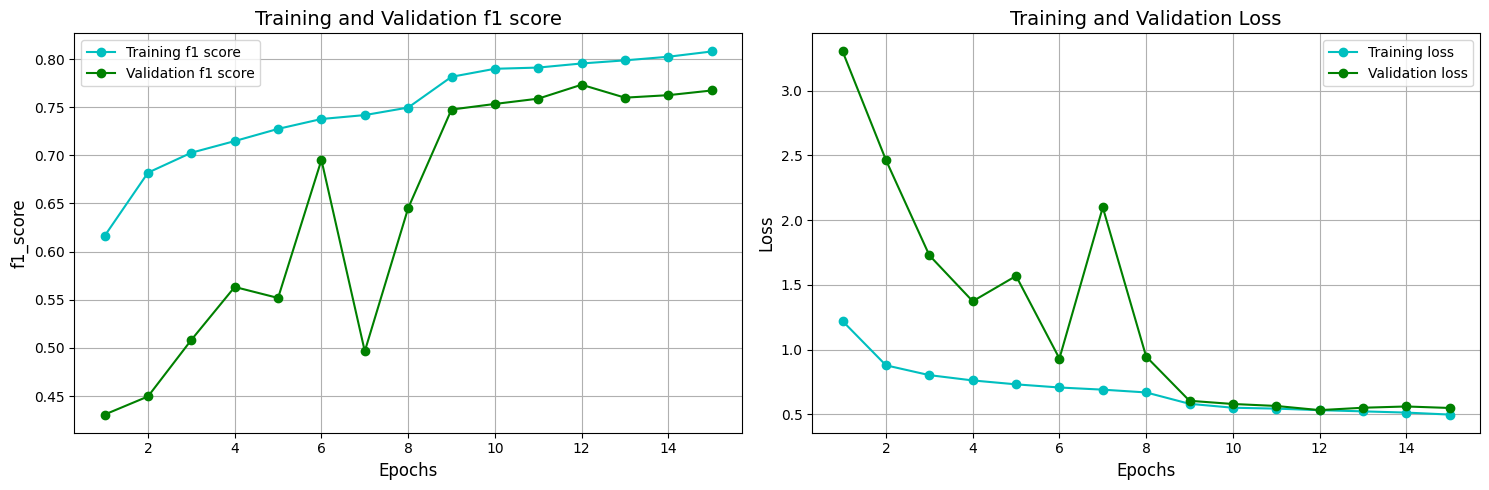

In [162]:
show_history_plot(history.history)

*Модель не переобучилась* 

### Confision matrix

In [175]:
def show_conf_matrix(model: Any, test_gen: Any) -> None:
    """
    Отображает графика confusion matrix и classification report.

    Parameters
    ----------
    model: Any 
        Обученная модель.
    test_gen: Any 
        Генератор тестовых данных.

    Returns
    -------
    None
        Вывод графика confusion matrix и classification report.
    """
    # сделаем сброс генератора, чтобы он точно начал с начала
    test_gen.reset()

    # сделаем предсказание на тестовых данных
    y_pred = model.predict(test_gen, verbose=1)

    # соотвествие закодированных меток классов
    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes
    labels = list(set(y_pred_labels))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels, labels=labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=classes)

    # график confusion matrix
    cmap = plt.cm.viridis
    cm_display.plot(cmap=cmap, colorbar=False, xticks_rotation='vertical')

    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # classification report
    print('Classification Report')
    print('-' * 30)
    print(classification_report(y_true, y_pred_labels, target_names=classes))

320/320 ━━━━━━━━━━━━━━━━━━━━ 208s 650ms/step


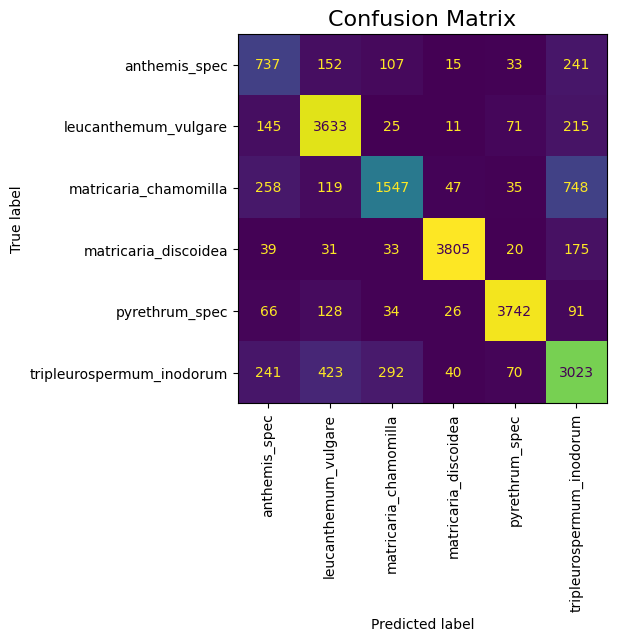

Classification Report
------------------------------
                           precision    recall  f1-score   support

            anthemis_spec       0.50      0.57      0.53      1285
     leucanthemum_vulgare       0.81      0.89      0.85      4100
    matricaria_chamomilla       0.76      0.56      0.65      2754
     matricaria_discoidea       0.96      0.93      0.95      4103
           pyrethrum_spec       0.94      0.92      0.93      4087
tripleurospermum_inodorum       0.67      0.74      0.70      4089

                 accuracy                           0.81     20418
                macro avg       0.77      0.77      0.77     20418
             weighted avg       0.81      0.81      0.81     20418



In [176]:
show_conf_matrix(model=model,
                 test_gen=test_generator,
                 batch_size=batch_size)

*Модель может отличать классы*

### Evaluation Matrix

In [183]:
def evaluation_matrix(df_test: pd.DataFrame, batch_size: int, model: Any,
                      train_gen: Any, val_gen: Any, test_gen: Any) -> None:
    """
    Оценивает модель на обучающем, валидационном и тестовом наборах данных.

    Parameters
    ----------
    df_test: pd.DataFrame
        Тестовый датасет.
    batch_size: int
        Размер батча.
    model: Any
        Обученная модель.
    train_gen: Any 
        Генератор тренировочных данных.
    val_gen: Any 
        Генератор валидационных данных.
    test_gen: Any 
        Генератор тестовых данных.

    Returns
    -------
    None
        Вывод метрик на обучающем, валидационном и тестовом наборах данных.
    """
    test_steps = len(df_test) // batch_size
    train_score = model.evaluate(train_generator, steps=test_steps, verbose=1)
    valid_score = model.evaluate(val_generator, steps=test_steps, verbose=1)
    test_score = model.evaluate(test_generator, steps=test_steps, verbose=1)

    header = "{:<12} {:<10} {:<10} {:<10}".format("", "Loss", "Accuracy",
                                                  "F1-score")
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f} {:<10.5f}".format(
        "Train", train_score[0], train_score[1], train_score[2])
    valid_row = "{:<12} {:<10.5f} {:<10.5f} {:<10.5f}".format(
        "Validation", valid_score[0], valid_score[1], valid_score[2])
    test_row = "{:<12} {:<10.5f} {:<10.5f} {:<10.5f}".format(
        "Test", test_score[0], test_score[1], test_score[2])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    
    print(table)

In [184]:
evaluation_matrix(df_test=df_test,
                  batch_size=batch_size,
                  model=model,
                  train_gen=train_generator,
                  val_gen=val_generator,
                  test_gen=test_generator)

319/319 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.8503 - f1_score: 0.8193 - loss: 0.4279
319/319 ━━━━━━━━━━━━━━━━━━━━ 161s 504ms/step - accuracy: 0.8097 - f1_score: 0.7664 - loss: 0.5528
319/319 ━━━━━━━━━━━━━━━━━━━━ 225s 706ms/step - accuracy: 0.8089 - f1_score: 0.7683 - loss: 0.5475
             Loss       Accuracy   F1-score  
---------------------------------------------
Train        0.43073    0.84782    0.81591   
Validation   0.54726    0.80983    0.76735   
Test         0.54774    0.80745    0.76712   


*Модель не переобучилась*

# Выводы

- лучшей базовой моделью оказалась MobileNetV2;
- лучший результат на тестовых данных составил: F1-score - 0.76712, accuracy - 0.80745, loss - 0.54774 ;
- основываясь на матрице ошибок, можно сделать вывод о том, что модель способна отличать ромашку аптечную и ее примеси;
- меньше всего ошибок модель делает при определении наиболее отличащихся по внешнему примесей: Ромашка пахучая (Matricaria discoidea), Поповник (Leucanthemum vulgare), виды Пиретрума (Tanacetum parthenium, Tanacetum corymbosum);
- хуже всего модель определяет виды Пупавки (Anthemis cotula, Anthemis arvensis, Anthemis ruthenica), что может быть связано с малым количеством примеров, а также большим сходством с другими растеними - в большей степени с Трёхрёберником (Tripleurospermum inodorum);
- среди всех примесей Ромашки аптечной (Matricaria chamomilla) сложнее всего ее отличить по внешнему виду от Трёхрёберника (Tripleurospermum inodorum) за счет их большого сходства;
- для улучшения качества модели ее можно дообучить на дополнительных размеченных данных изображений.